In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
%matplotlib inline
import tensorflow.keras as keras
from keras import models
import numpy as np
import shutil
import pandas as pd

from keras import backend as K

In [27]:
output_df = pd.read_csv('../test_data/output_dataset040_20201004/transfer_learning_model/damage_other/output.csv')

# Model performance 

In [28]:
threshold_list = [0, 0.00000001, 0.000001, 0.0001, 0.001, 0.01, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 
                  0.70, 0.80, 0.90, 0.99, 0.999, 0.99999, 1]

In [29]:
results_dict  = {}
for threshold in threshold_list:
    
    # Creates a copy of output_df so that the original remains unchanged since iteration is done over
    # every threshold value and the temporary dataframe temp_df resets
    
    temp_df = output_df.copy(deep=True)
    
    # Generates a boolean column of whether the predicted value is more than threshold or not
    temp_df['threshold_test'] = temp_df['output'] >= threshold
    
    # Generates a boolean column of whether the image is of a damage building or not
    temp_df['ground_truth'] = temp_df['image'].str.contains('damage')

    # Creates a subset dataframe of only images that are damage per ground truth
    true_damage_filtered = temp_df[temp_df['ground_truth']]

    # Makes calculations
            # True in threshold_test means the image is classified as 'damage' and is also 'damage' per ground truth  
    damage_correct = len(true_damage_filtered[true_damage_filtered['threshold_test']])
    damage_incorrect = len(true_damage_filtered) - damage_correct
    
    # Creates a subset dataframe of only images that are not damage per ground truth
    true_other_filtered = temp_df[~temp_df['ground_truth']]

    # Makes calculations
        # True in threshold_test means the image is classified as 'damage' but it is 'other' per ground truth  
    other_incorrect = len(true_other_filtered[true_other_filtered['threshold_test']])
    other_correct = len(true_other_filtered) - other_incorrect

    # Used try function because some denominators may be zero; thershold values that generate such ratios are excluded
    # from results altogether
    try:

        damage_precision = damage_correct/(damage_correct + other_incorrect)
        damage_recall = damage_correct/(damage_correct + damage_incorrect)
        damage_fmeasure = 2 * damage_precision * damage_recall / (damage_precision + damage_recall)
        other_precision = other_correct/(other_correct + damage_incorrect)
        other_recall = other_correct/(other_correct + other_incorrect)
        other_fmeasure = 2 * other_precision * other_recall / (other_precision + other_recall)
        product_fmeasure = damage_fmeasure * other_fmeasure
        accuracy = (damage_correct + other_correct) / (len(temp_df['image']))

        
        
    except:
        continue
    fpr = other_incorrect / (other_incorrect + other_correct)
    tpr = damage_correct / (damage_correct + damage_incorrect)
    results_dict[threshold] = [damage_precision, damage_recall, damage_fmeasure, other_precision, other_recall, other_fmeasure, product_fmeasure, accuracy, fpr, tpr]
    
# Converts results dictionary to dataframe    
results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns = ['damage_precision', 'damage_recall', 'damage_fmeasure', 'other_precision', 'other_recall', 'other_fmeasure', 'product_fmeasure', 'accuracy', 'fpr', 'tpr'])
results_df.sort_index(inplace=True)

In [30]:
n_damage = len(output_df[output_df['groundTruth'] == 1])
n_other = len(output_df[output_df['groundTruth'] == 0])

(0.5, 1.0)

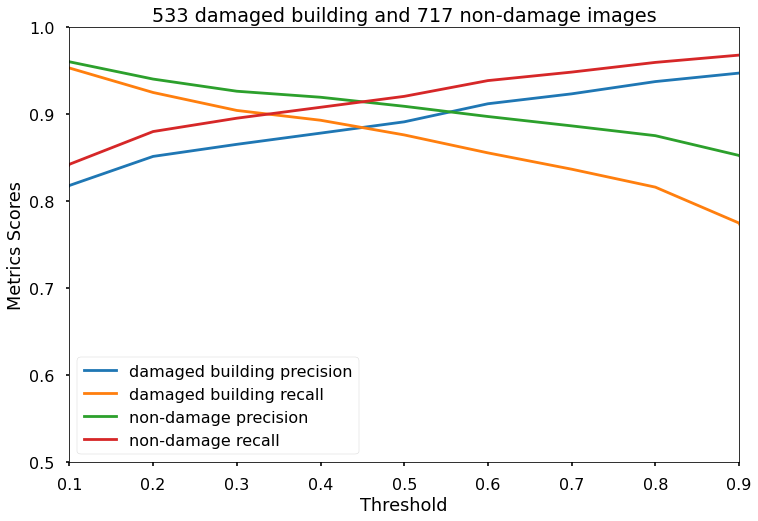

In [31]:
# Generates fmeasure curve as a function of chosen threshold

plt.figure(figsize=(12,8))
ax = plt.subplot(111)
results_df.plot(use_index=True, y='damage_precision', ax=ax, label="damaged building precision")
results_df.plot(use_index=True, y='damage_recall', ax=ax, label="damaged building recall")
results_df.plot(use_index=True, y='other_precision', ax=ax, label="non-damage precision")
results_df.plot(use_index=True, y='other_recall', ax=ax, label="non-damage recall")
plt.title('%d damaged building and %d non-damage images'%(n_damage, n_other))
ax.set_xlabel('Threshold')
ax.set_ylabel('Metrics Scores')

plt.xlim(0.1, 0.9)
plt.ylim(0.5, 1)